# Initialization

In [1]:
import tensorflow as tf

### Configuration
create_dataset = False

def in_google_colab():
    """Checks if the code is running in Google Colab

    Returns:
        bool: _description_
    """
    try:
        import google.colab
        return True
    except ImportError:
        return False

if in_google_colab():
    print("Running in Google Colab")
    # Install necessary packages in Google Colab
    !rm -r sample_data/
    !git clone https://github.com/naderinho/anesthesia_anomaly_detection
    !cp -r anesthesia_anomaly_detection/* .
    !rm -r anesthesia_anomaly_detection/
    !pip install vitaldb
    create_dataset = False
else:
    print("Running locally")

### Datasetpath
directory = 'data/'
datasetpath = 'dataset03/'
vitaldbpath = 'vitaldb_sevofl/'

### Import the necessary libraries
import numpy as np
import pandas as pd
import vitaldb as vf
import matplotlib.pyplot as plt
import pickle

### Custom functions
import modules as md

Running locally


# Data loading

In [2]:
###### Create Dataset
if create_dataset:
    bis = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
    bis.name = 'Bispektralindex'
    bis.tracks = ['BIS/BIS']
    bis.filter = [20, 10, 100]
    bis.generateDataset(normalization=md.NormNone)
    bis.save('00_bis.npz')

    info = md.infoImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
    info.generateDataset(normalization=md.NormStandard)
    info.save('01_info.npz')

    bloodpressure = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
    bloodpressure.name = 'bloodpressure'
    bloodpressure.tracks = ['Solar8000/ART_DBP', 'Solar8000/ART_MBP', 'Solar8000/ART_SBP']
    bloodpressure.filter = [20, 20, 250]
    bloodpressure.generateDataset(normalization=md.NormStandard)
    bloodpressure.save('02_bloodpressure.npz')

    etCO2 = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
    etCO2.name = 'End Tidal CO2'
    etCO2.tracks = ['Primus/ETCO2']
    etCO2.filter = [5, 15, 50]
    etCO2.generateDataset(normalization=md.NormStandard)
    etCO2.save('02_etCO2.npz')

    spO2 = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
    spO2.name = 'SpO2'
    spO2.tracks = ['Solar8000/PLETH_SPO2']
    spO2.filter = [3, 80, 100]
    spO2.generateDataset(normalization=md.NormStandard)
    spO2.save('02_spO2.npz')

    hr = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
    hr.name = 'Heart Rate'
    hr.tracks = ['Solar8000/HR']
    hr.filter = [20, 40, 180]
    hr.generateDataset(normalization=md.NormStandard)
    hr.save('02_hr.npz')

    mac = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
    mac.name = 'MAC'
    mac.tracks = ['Primus/MAC']
    mac.filterON = False
    mac.generateDataset(normalization=md.NormNone)
    mac.save('03_mac.npz')

### Load the datasets
bis = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
bis.load('00_bis.npz')

info = md.infoImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
info.load('01_info.npz')

bloodpressure = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
bloodpressure.load('02_bloodpressure.npz')

etCO2 = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
etCO2.load('02_etCO2.npz')

spO2 = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
spO2.load('02_spO2.npz')

hr = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
hr.load('02_hr.npz')

mac = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
mac.load('03_mac.npz')


train_index, val_index, test_index = bis.split(np.array(bis.index))

# Model creation

In [3]:
########################################## COMBINED MODEL ##########################################
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, LSTM, Dense, ReLU, Dropout, Concatenate, Masking, Conv1D, MaxPooling1D, BatchNormalization, RepeatVector, Lambda
from tensorflow.keras.metrics import RootMeanSquaredError, MeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError

### Blood Pressure Input
input_bp = Input(shape=(None, bloodpressure.train_dataset.shape[2]))
bp_layer = Masking(mask_value=0.0)(input_bp)

bp_layer = LSTM(units=64, return_sequences=True)(bp_layer)
bp_layer = BatchNormalization()(bp_layer)
bp_layer = LSTM(units=64, return_sequences=True)(bp_layer)
bp_layer = BatchNormalization()(bp_layer)
bp_layer = LSTM(units=64, return_sequences=True)(bp_layer)
bp_layer = BatchNormalization()(bp_layer)
bp_layer = LSTM(units=64, return_sequences=True)(bp_layer)
bp_layer = BatchNormalization()(bp_layer)
bp_layer = LSTM(units=128, return_sequences=True)(bp_layer)
bp_layer = BatchNormalization()(bp_layer)
bp_layer = LSTM(units=64, return_sequences=True)(bp_layer)
bp_layer = BatchNormalization()(bp_layer)
bp_layer = LSTM(units=16, return_sequences=True)(bp_layer)
bp_layer = BatchNormalization()(bp_layer)
bp_layer = LSTM(units=16, return_sequences=True)(bp_layer)
bp_layer = BatchNormalization()(bp_layer)
bp_layer = Dense(units=16, activation='linear')(bp_layer)

### etCO2 Input
input_co2 = Input(shape=(None, etCO2.train_dataset.shape[2]))

co2_layer = LSTM(units=64, return_sequences=True)(input_co2)
co2_layer = BatchNormalization()(co2_layer)
co2_layer = LSTM(units=64, return_sequences=True)(co2_layer)
co2_layer = BatchNormalization()(co2_layer)
co2_layer = LSTM(units=64, return_sequences=True)(co2_layer)
co2_layer = BatchNormalization()(co2_layer)
co2_layer = LSTM(units=16, return_sequences=True)(co2_layer)
co2_layer = BatchNormalization()(co2_layer)
co2_layer = LSTM(units=8, return_sequences=True)(co2_layer)
co2_layer = BatchNormalization()(co2_layer)
co2_layer = Dense(units=8, activation='linear')(co2_layer)

### spo2 Input
input_spo2 = Input(shape=(None, spO2.train_dataset.shape[2]))

spo2_layer = LSTM(units=64, return_sequences=True)(input_spo2)
spo2_layer = BatchNormalization()(spo2_layer)
spo2_layer = LSTM(units=64, return_sequences=True)(spo2_layer)
spo2_layer = BatchNormalization()(spo2_layer)
spo2_layer = LSTM(units=64, return_sequences=True)(spo2_layer)
spo2_layer = BatchNormalization()(spo2_layer)
spo2_layer = LSTM(units=16, return_sequences=True)(spo2_layer)
spo2_layer = BatchNormalization()(spo2_layer)
spo2_layer = LSTM(units=8, return_sequences=True)(spo2_layer)
spo2_layer = BatchNormalization()(spo2_layer)
spo2_layer = Dense(units=8, activation='linear')(spo2_layer)

# Sevoflurane layers
input_mac = Input(shape=(None, mac.train_dataset.shape[2]))
mac_layer = BatchNormalization()(input_mac)
mac_layer = LSTM(units=64, return_sequences=True)(mac_layer)
mac_layer = BatchNormalization()(mac_layer)
mac_layer = LSTM(units=64, return_sequences=True)(mac_layer)
mac_layer = BatchNormalization()(mac_layer)
mac_layer = LSTM(units=64, return_sequences=True)(mac_layer)
mac_layer = BatchNormalization()(mac_layer)
mac_layer = LSTM(units=64, return_sequences=True)(mac_layer)
mac_layer = BatchNormalization()(mac_layer)
mac_layer = LSTM(units=128, return_sequences=True)(mac_layer)
mac_layer = BatchNormalization()(mac_layer)
mac_layer = LSTM(units=64, return_sequences=True)(mac_layer)
mac_layer = BatchNormalization()(mac_layer)
mac_layer = LSTM(units=16, return_sequences=True)(mac_layer)
mac_layer = BatchNormalization()(mac_layer)
mac_layer = LSTM(units=16, return_sequences=True)(mac_layer)
mac_layer = BatchNormalization()(mac_layer)
mac_layer = Dense(units=16, activation='linear')(mac_layer)

### INFO layers
input_info = Input(shape=(info.train_dataset.shape[1],))
info_layer = RepeatVector(bloodpressure.train_dataset.shape[1])(input_info)
info_layer = Dense(units=16, activation='linear')(info_layer)
info_layer = Dense(units=16, activation='sigmoid')(info_layer)


## Concatenate the Sevoflurane output with the info layer
comb_layer = Concatenate()([bp_layer, co2_layer, spo2_layer, mac_layer, info_layer])
comb_layer = Dense(units=64, activation='linear')(comb_layer)
comb_layer = Dense(units=64, activation='relu')(comb_layer)
comb_layer = Dense(units=64, activation='relu')(comb_layer)
comb_layer = Dense(units=32, activation='relu')(comb_layer)
comb_layer = Dense(units=16, activation='relu')(comb_layer)
comb_layer = Dense(units=1, activation=ReLU(max_value=1.0))(comb_layer)
output = Lambda(lambda x: x * 100)(comb_layer)

# Define the model
model = Model(inputs=[input_bp, input_co2, input_spo2, input_mac, input_info], outputs=output)

# Compile the model
optimizer = Adam(learning_rate=0.0005)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['MeanSquaredError','MeanAbsoluteError','RootMeanSquaredError']
              )

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, 3)]            0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, None, 1)]            0         []                            
                                                                                                  
 masking (Masking)           (None, None, 3)              0         ['input_1[0][0]']             
                                                                                                  
 batch_normalization_18 (Ba  (None, None, 1)              4         ['input_4[0][0]']             
 tchNormalization)                                                                            

# Model Training

In [8]:
# Rolling mean on BIS data
y = pd.DataFrame(bis.train_dataset[:,:,0].T).rolling(min_periods=1,window=3, center=True).mean().to_numpy().T[:,:,np.newaxis]

# Define training stop criteria
class StopTrainingCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(StopTrainingCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_loss') is not None:
            if logs.get('val_loss') < self.threshold:
                print(f"\nValidation loss is below {self.threshold}, stopping training.")
                self.model.stop_training = True

stop_training_callback = StopTrainingCallback(threshold = 35)


if in_google_colab():
    # Train the model
    history = model.fit([bloodpressure.train_dataset, etCO2.train_dataset, spO2.train_dataset, mac.train_dataset, info.train_dataset],
                        y,
                        validation_data=([bloodpressure.validation_dataset, etCO2.validation_dataset, spO2.validation_dataset, mac.validation_dataset, info.validation_dataset], bis.validation_dataset),
                        epochs=150,
                        callbacks=[stop_training_callback],
                        batch_size=4
                        )

    train_score = history.history

    # Save the model
    model.save('download/model.keras')

    # Save the training history
    with open('download/train_score.pkl', 'wb') as f:
        pickle.dump(train_score, f)

    # Save the prediction
    y_pred = model.predict([bloodpressure.test_dataset, etCO2.test_dataset, spO2.test_dataset, mac.test_dataset, info.test_dataset], verbose=0)
    with open('download/prediction.pkl', 'wb') as f:
        pickle.dump(y_pred, f)

else: 
    # Load train score data
    with open('train_score.pkl', 'rb') as f:
        train_score = pickle.load(f)
    
    # Load test prediction data
    with open('prediction.pkl', 'rb') as f:
        y_pred = pickle.load(f)

# Training results

In [17]:
def training_loss_plot(train_score, filename: str = None):

    epoch = range(1,len(train_score['loss'])+1)

    # Plot configuration
    plt.figure(figsize=(15/2.54, 8/2.54))
    plt.rcParams['font.size'] = 10

    color1 = (0, 0, 0)
    color2 = (1, 1, 1)
    color3 = (159/255, 182/255, 196/255)
    color4 = (125/255, 102/255, 102/255)
    color5 = (153/255, 0, 0)

    # Actual plot
    plt.plot(epoch, train_score['loss'], label='Training Loss', color=color1, marker='^', markerfacecolor=color1)
    plt.plot(epoch, train_score['val_loss'], label='Validation Loss', color=color1, marker='s', markerfacecolor=color2)

    # Title and labels
    #plt.title('Training Model loss')
    plt.xlabel('Training Epoch')
    plt.ylabel('Training Loss')
    plt.yscale("log")
    plt.xlim(0, len(train_score['loss'])+1)
    plt.legend(loc='lower center', bbox_to_anchor=(1.25, 0.78))

    # Axis settings
    ax = plt.gca()
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)

    x = epoch[-1] * 1.1

    y1 = 10
    ax.set_ylim(bottom=y1)

    plt.text(x, y1, s='Batch-Größe: 4', fontsize=10)
    y2 = y1 + 7
    y0 = y1

    plt.text(x, y2, s='Training: '+ '{:d}'.format(len(train_score['loss']))+ ' Epochen', fontsize=10)
    y0 = y1
    y1 = y2
    y2 = y1**2 / y0


    plt.text(x, y2, s='Loss: Mean Squared Error', fontsize=10)
    y0 = y1
    y1 = y2
    y2 = y1**2 / y0

    plt.text(x, y2, s='Optimierer: Adam', fontsize=10)
    y0 = y1
    y1 = y2
    y2 = y1**2 / y0

    plt.text(x, y2, s='Modellparameter:', fontsize=10, fontweight='bold')

    plt.grid(True, linewidth=1.0)
    if filename != None:
        plt.savefig(filename, bbox_inches='tight', pad_inches=0.2, format='pdf')

    return plt

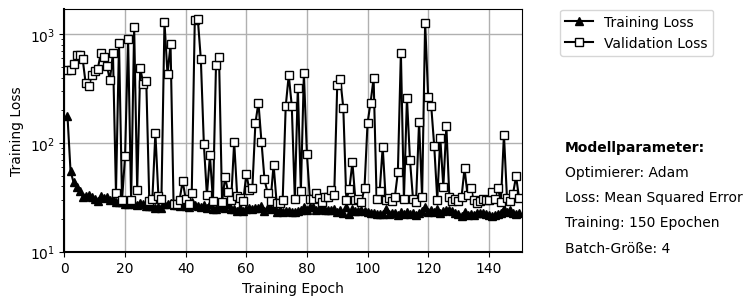

In [18]:
plot = training_loss_plot(train_score, filename='download/training_loss.pdf')
plot.show()

# Testing

In [19]:
def get_anaesthesia_phases_balanced(bis_dataset: np.array ,mac_dataset: np.array, N: int = 60) -> dict:
    anesthesia_phases = []
    
    for bis, mac in zip(bis_dataset, mac_dataset):
        conv_bis = np.convolve(bis[:,0], np.ones(N)/N, mode='valid')
        conv_mac = np.convolve(mac[:,0], np.ones(N)/N, mode='valid')
        index1 = np.argmax(conv_bis < 60) + 2 * N
        index2 = np.where(conv_mac > 0.5)[0][-1] - N
        anesthesia_phases.append([index1, index2])

    return anesthesia_phases

def phases_report(prediction: np.array, groundtruth: np.array, mac: np.array) -> pd.DataFrame:
    """
    From a given BIS prediction with the corresponding groundtruth values, this function
    calculates the MSE, MAE and RMSE for the whole dataset and the three anesthesia phases
    (Induction, Maintenance, Recovery). The function also calculates the same metrics for a
    baseline model that always predicts a BIS value of 41.0.

    Args:
        prediction (np.array): predicted BIS values
        groundtruth (np.array): measured BIS values
        propofolrate (np.array): infusion rate of propofol 20mg/ml in ml/h

    Returns:
        pd.DataFrame: with the calculated metrics for the whole dataset and the three anesthesia phases
    """

    baseline = np.ones(groundtruth.shape) * 41.0

    phases = get_anaesthesia_phases_balanced(bis_dataset=groundtruth, mac_dataset=mac)

    # Create the three datasets
    all_pred, induction_pred, maintenance_pred, recovery_pred = np.copy(prediction), np.copy(prediction), np.copy(prediction), np.copy(prediction)
    all_base, induction_base, maintenance_base, recovery_base = np.copy(baseline), np.copy(baseline), np.copy(baseline), np.copy(baseline)

    all_pred[groundtruth == 0.0] = np.nan
    all_base[groundtruth == 0.0] = np.nan

    for i, phase in enumerate(phases):
        induction_pred[i,phase[0]:-1,:] = np.nan
        maintenance_pred[i,0:phase[0],:] = np.nan
        maintenance_pred[i,phase[1]:-1,:] = np.nan
        recovery_pred[i,0:phase[1],:] = np.nan
        recovery_pred[i,np.where(groundtruth[i] == 0)[0][0]:-1,:] = np.nan

        induction_base[i,phase[0]:-1,:] = np.nan
        maintenance_base[i,0:phase[0],:] = np.nan
        maintenance_base[i,phase[1]:-1,:] = np.nan
        recovery_base[i,0:phase[1],:] = np.nan
        recovery_base[i,np.where(groundtruth[i] == 0)[0][0]:-1,:] = np.nan

    table_index = ['All', 'Induction', 'Maintenance', 'Recovery']

    results = pd.DataFrame(index=table_index, columns=['Prediction MSE', 'Baseline MSE', 'Prediction MAE', 'Baseline MAE', 'Prediction RMSE', 'Baseline RMSE'])

    for i, section in enumerate([[all_pred, all_base], [induction_pred, induction_base], [maintenance_pred, maintenance_base], [recovery_pred, recovery_base]]):
        results.loc[table_index[i]] = [
            np.nanmean(np.square(groundtruth - section[0])),           # MSE Prediction
            np.nanmean(np.square(groundtruth - section[1])),           # MSE Baseline
            np.nanmean(np.abs(groundtruth - section[0])),              # MAE Prediction
            np.nanmean(np.abs(groundtruth - section[1])),              # MAE Baseline
            np.sqrt(np.nanmean(np.square(section[0] - groundtruth))),   # RMSE Prediction
            np.sqrt(np.nanmean(np.square(section[1] - groundtruth)))    # RMSE Baseline
        ]

    return results

def phases_report_std(report: pd.DataFrame, prediction: np.array, groundtruth: np.array, propofolrate: np.array) -> pd.DataFrame:
    sets = prediction.shape[0]

    evaluation = np.zeros((sets,4,6))

    for i in range(0,sets):
        evaluation[i] = phases_report(prediction[i:i+1], groundtruth[i:i+1], propofolrate[i:i+1])

    # Prediction RMSE min/max (5)

    table_index = ['All     ', 'Induction', 'Maintenance', 'Recovery']

    for j, phase in enumerate(table_index):
        print(phase, '\tmin: \t', np.argmin(evaluation[:,j,5]), '\tmax: \t', np.argmax(evaluation[:,j,5])),'(', '{:.3f}'.format(np.max(evaluation[:,j,5]))

    data = np.std(evaluation, axis=0)
    return pd.DataFrame(data, index=report.index, columns=report.columns)

In [20]:
### Predict on the test set

print('Testmetriken:')

report = phases_report(y_pred, bis.test_dataset, mac.test_dataset)
report

Testmetriken:


,Prediction MSE,Baseline MSE,Prediction MAE,Baseline MAE,Prediction RMSE,Baseline RMSE
All,70.71537,140.134619,6.229971,7.918904,8.409244,11.837847
Induction,162.513504,548.868312,9.250764,16.411629,12.748078,23.427939
Maintenance,55.780708,61.226926,5.686854,6.160038,7.468648,7.824764
Recovery,122.373138,516.471279,8.312262,16.818114,11.06224,22.726004


In [21]:
phases_report_std(report, y_pred, bis.test_dataset, mac.test_dataset)

All      	min: 	 28 	max: 	 39
Induction 	min: 	 5 	max: 	 39
Maintenance 	min: 	 33 	max: 	 39
Recovery 	min: 	 21 	max: 	 20


,Prediction MSE,Baseline MSE,Prediction MAE,Baseline MAE,Prediction RMSE,Baseline RMSE
All,50.024077,65.945299,2.577474,2.610426,2.607257,2.552217
Induction,131.986922,320.521647,3.361732,6.029556,4.136455,7.118310
Maintenance,52.155659,45.584684,2.805127,2.620447,2.932396,2.603604
Recovery,111.683156,234.119247,4.092531,5.358649,4.369764,4.951086


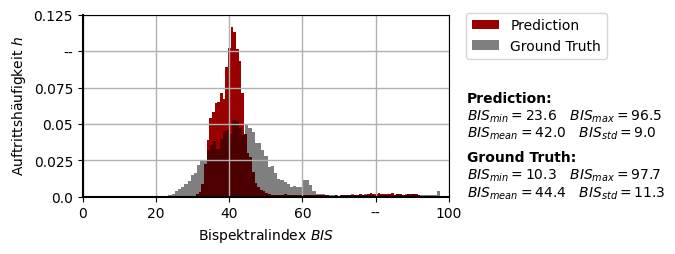

In [22]:
from utils.plotting import full_histogramm_plot

plot = full_histogramm_plot(groundtruth = bis.test_dataset, prediction = y_pred, filename='download/histogramm.pdf')
plot.show()

In [23]:
def single_prediction_plot(case: int, index: np.array, groundtruth: np.array, prediction: np.array, mac: np.array = None, error: bool = None, filename: str = None):

    j = np.where(index == case)[0][0]

    end = np.where(groundtruth[j] == 0)[0][0]

    time = np.arange(0, prediction[j,:end].shape[0]) * 10 / 60

    plt.figure(figsize=(12/2.54, 6/2.54))
    plt.rcParams['font.size'] = 10

    # Colors
    color1 = (0, 0, 0)
    color2 = (1, 1, 1)
    color3 = (159/255, 182/255, 196/255)
    color4 = (125/255, 102/255, 102/255)
    color5 = (153/255, 0, 0)

    plt.plot(time,groundtruth[j,:end], label='Ground Truth', color=color1)
    plt.plot(time,prediction[j,:end], label='Prediction', color=color5)
    
    plt.xlabel('Operationszeit $t_{OP}$')
    plt.ylabel('Bispektralindex $BIS$')

    # Axis settings
    ax = plt.gca()
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)

    # Limits
    ax.set_ylim(bottom=0, top=100)
    ax.set_xlim(left=0, right=time[-1])

    # Einheiten auf x-Achse
    xunit = 'min'
    ticks = ax.get_xticks()
    ticks = [int(tick) for tick in ticks]
    ticks_with_units = [xunit if i == len(ticks) - 2 else ticks[i] for i in range(len(ticks))]
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks_with_units)

    # Einheiten auf y-Achse
    yunit = '--'
    ticks = ax.get_yticks()
    ticks = [int(tick) for tick in ticks]
    ticks_with_units = [yunit if i == len(ticks) - 2 else ticks[i] for i in range(len(ticks))]
    ax.set_yticks(ticks)
    ax.set_yticklabels(ticks_with_units)

    plt.grid(True, linewidth=1.0)

    x = ax.get_xticks()[-1] * 1.05
    x2 = ax.get_xticks()[-1] * 1.3

    ### Show prediction error
    if error is not None:
        error_calc = phases_report(prediction[j:j+1], groundtruth[j:j+1], mac[j:j+1])[error]
        plt.text(x, 50, s= error + ':', fontweight='bold')
        plt.text(x, 36, s='Gesamt:')
        plt.text(x, 24, s='Einleitung:')
        plt.text(x, 12, s='Narkose:')
        plt.text(x, 0,  s='Ausleitung:')
        plt.text(x, -22,  s='Case-ID:')

        plt.text(x2, 36, s='{:.2f}'.format(error_calc['All']))
        plt.text(x2, 24, s='{:.2f}'.format(error_calc['Induction']))
        plt.text(x2, 12, s='{:.2f}'.format(error_calc['Maintenance']))
        plt.text(x2, 0,  s='{:.2f}'.format(error_calc['Recovery']))
        plt.text(x2, -22,s=str(case))
    else: 
        sex = cases.loc[case]['sex'].replace("M", "Männlich").replace("F", "Weiblich")
        
        plt.text(x, 50, s='Fallinformationen:', fontweight='bold')
        plt.text(x, 36, s='Case ID: ' + str(case))
        plt.text(x, 24, s='Alter: ' + str(int(cases.loc[case]['age'])) + ' Jahre')
        plt.text(x, 12, s='Geschlecht: ' + sex)
        plt.text(x, 0,  s='BMI: ' + str(cases.loc[case]['bmi']))

    ### Legend
    dy = 0
    if mac is None:
        dy = 0.1
    plt.legend(loc='lower center', bbox_to_anchor=(1.25, 0.6+dy))

    if filename != None:
        plt.savefig(filename, bbox_inches='tight', pad_inches=0.2, format='pdf')

    return plt

/var/folders/j7/bw9_d4_d3vl_bdbfc7_pz7p40000gp/T/ipykernel_27443/1776440685.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12/2.54, 6/2.54))


Finished


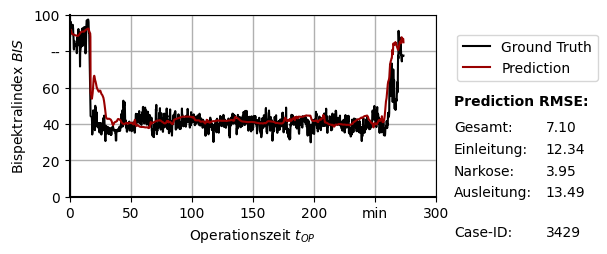

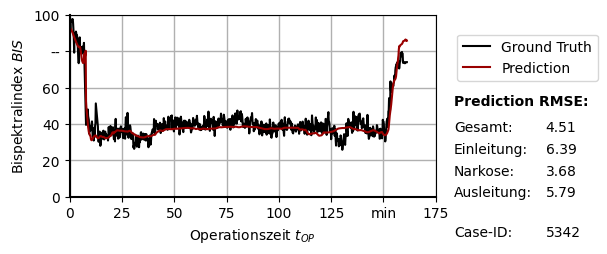

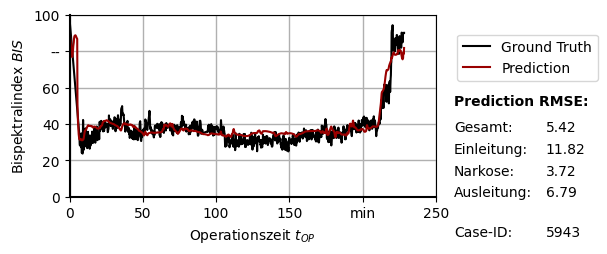

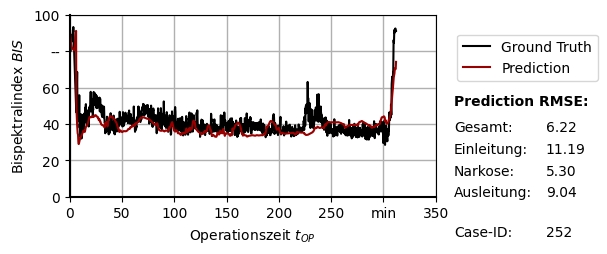

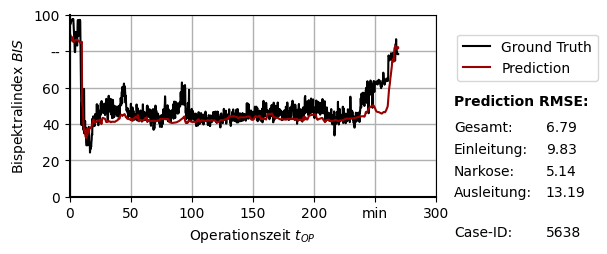

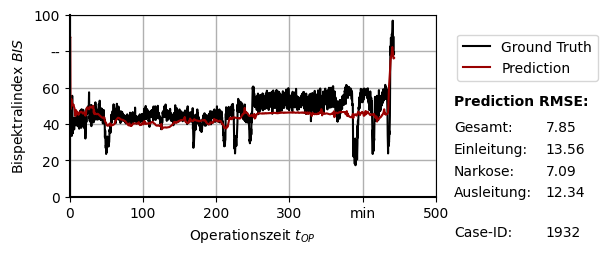

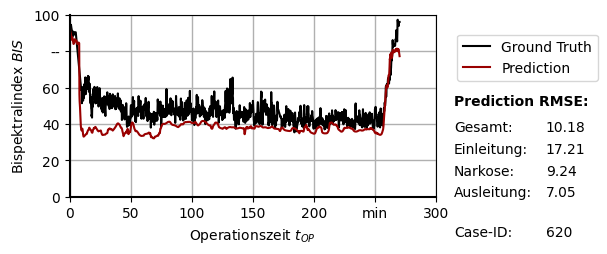

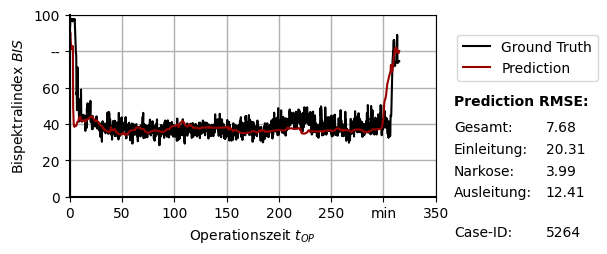

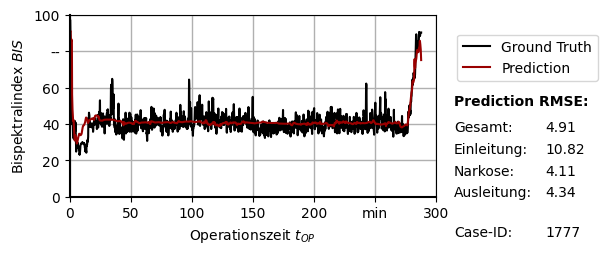

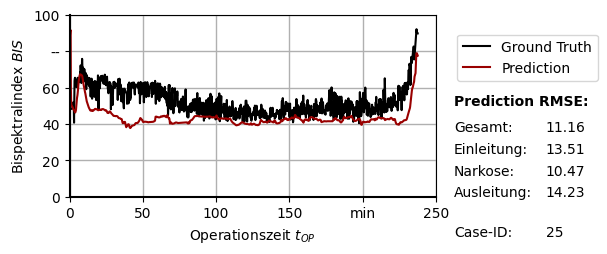

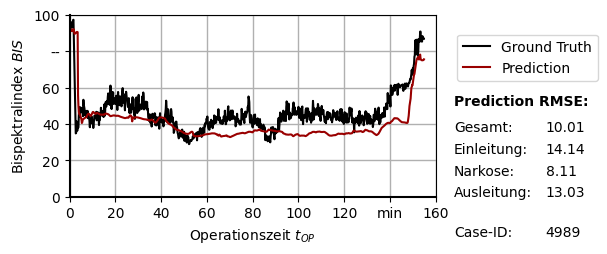

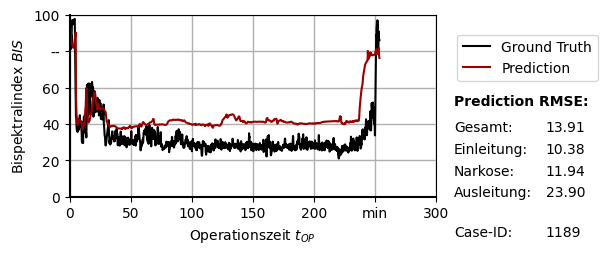

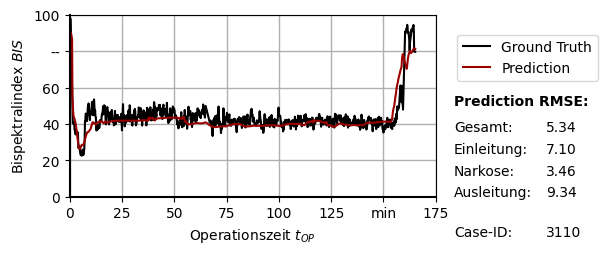

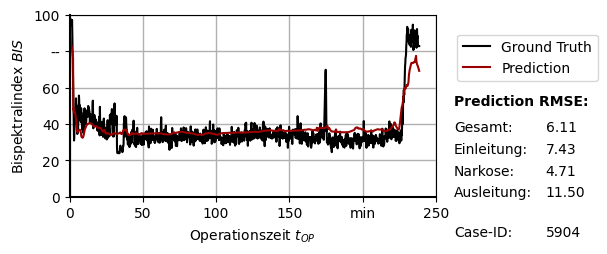

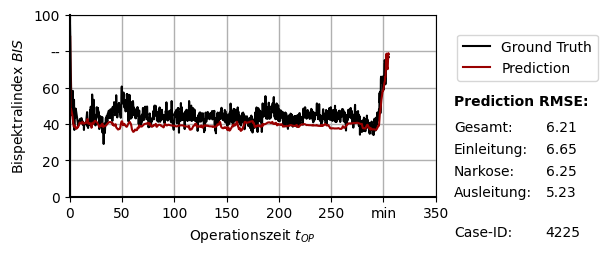

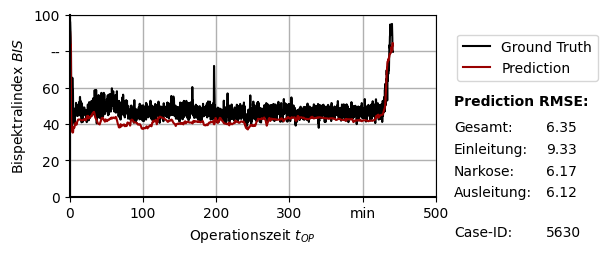

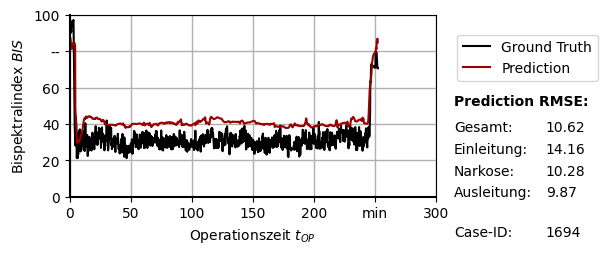

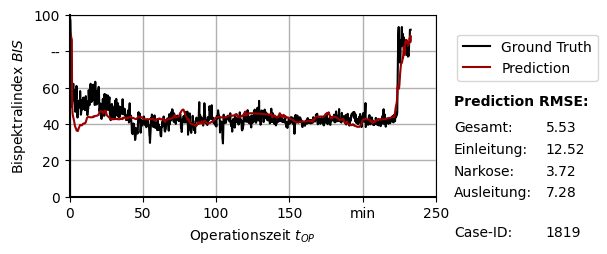

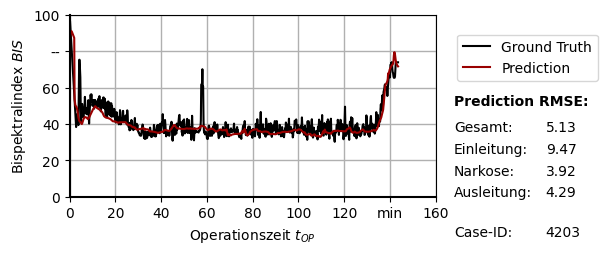

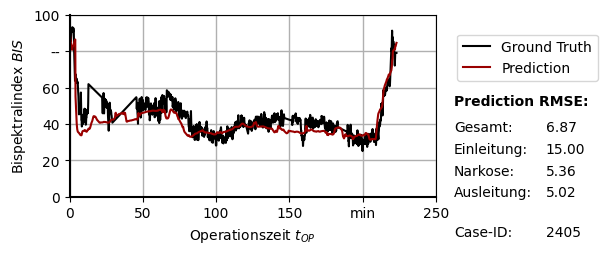

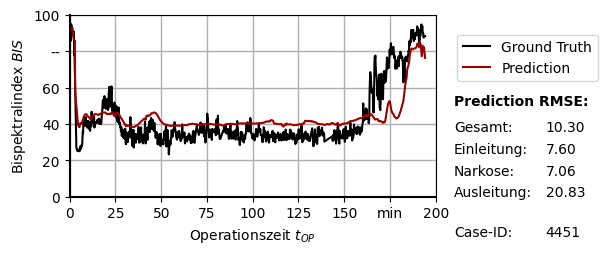

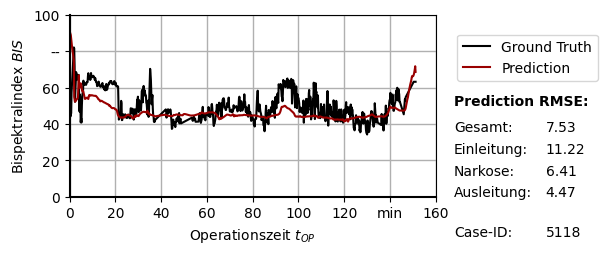

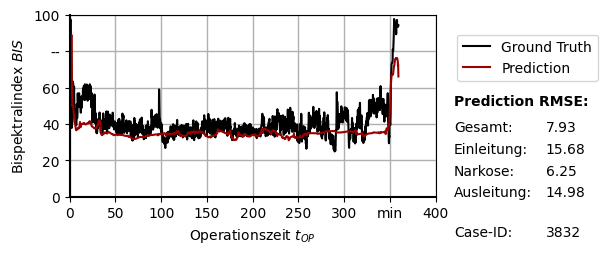

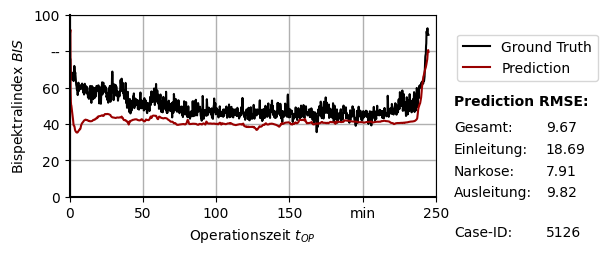

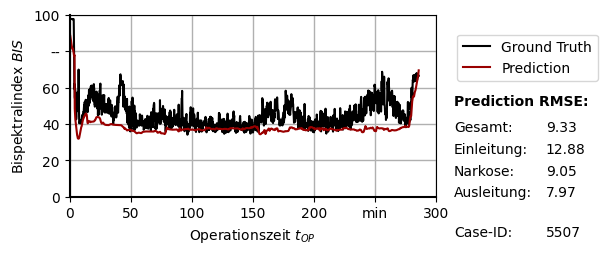

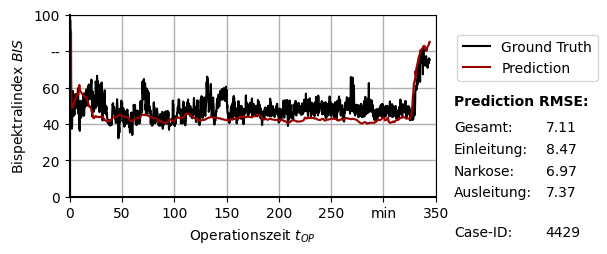

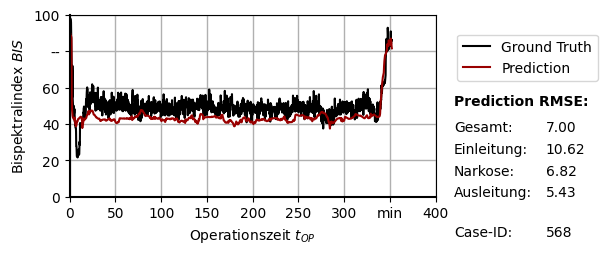

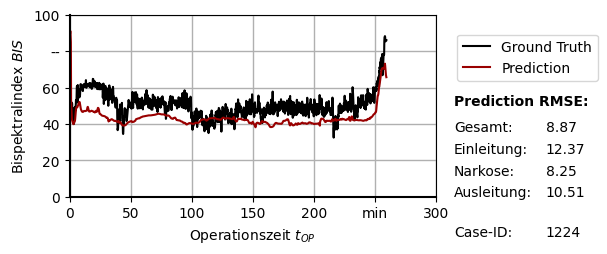

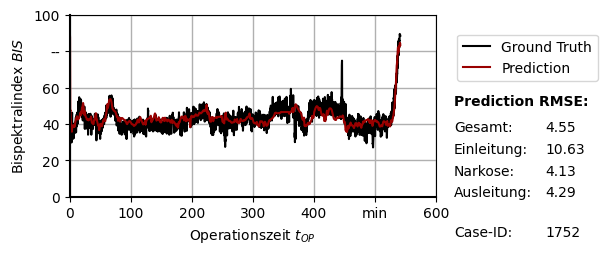

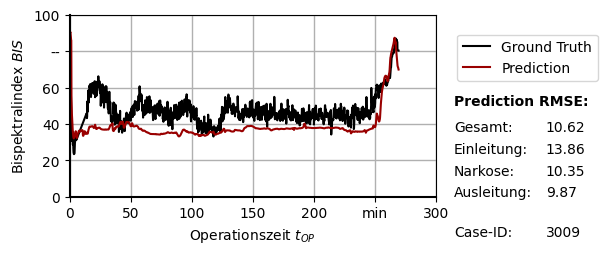

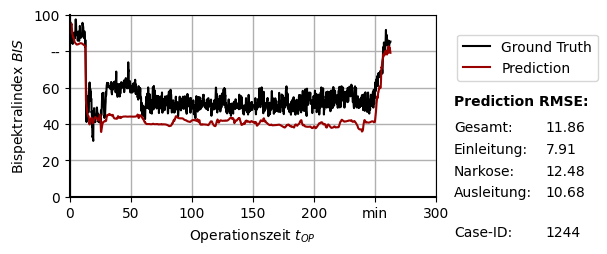

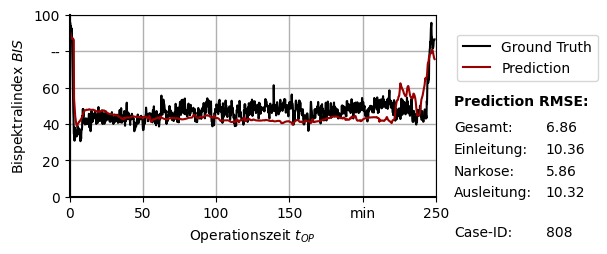

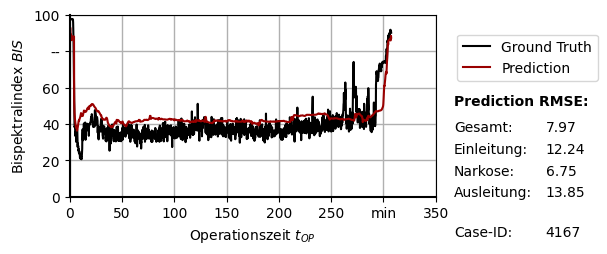

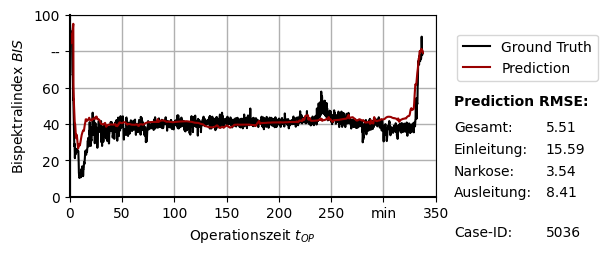

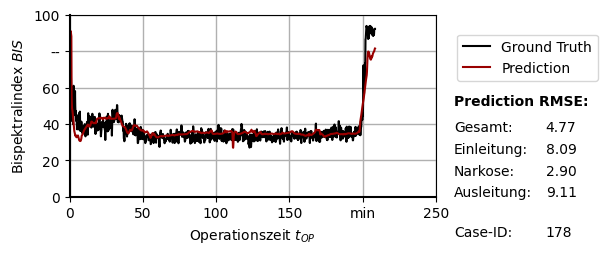

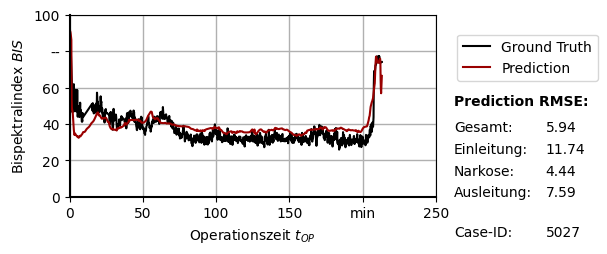

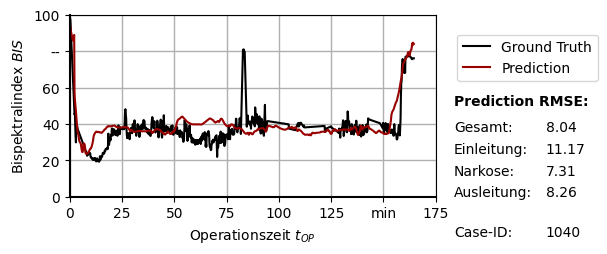

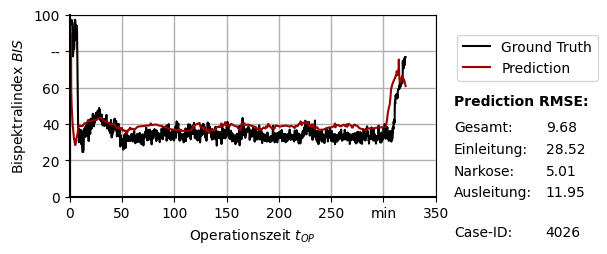

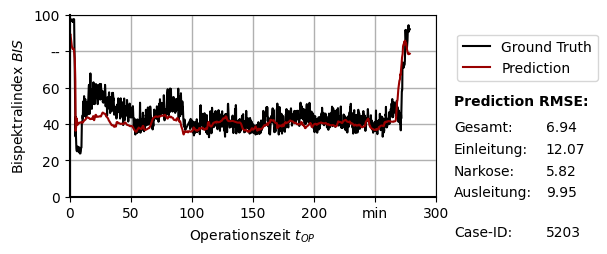

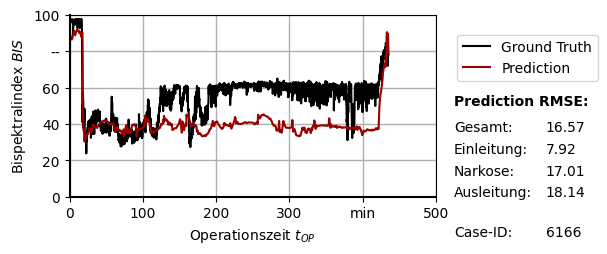

In [24]:
for case in test_index:
    single_prediction_plot(
        case = case, 
        index = test_index, 
        groundtruth = bis.test_dataset, 
        prediction = y_pred, 
        mac = mac.test_dataset, 
        error = 'Prediction RMSE',
        filename = 'download/' + str(case) + '.pdf')

print('Finished')

In [ ]:
from utils.plotting import full_prediction_plot

full_prediction_plot(index = test_index, groundtruth = bis.test_dataset, prediction = y_pred, infusion = mac.test_dataset)